In [1]:
import os, csv
import pandas as pd
import numpy as np

input_directory = 'data/personal'
input_filename = 'gnss_log_2020_12_03_19_43_12.txt'

with open(os.path.join(input_directory, input_filename)) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if row[0][0] == '#':
            if 'Fix' in row[0]:
                android_fixes = [row[1:]]
            elif 'Raw' in row[0]:
                measurements = [row[1:]]
        else:
            if 'Fix' in row[0]:
                android_fixes.append(row[1:])
            elif row[0] == 'Raw':
                measurements.append(row[1:])

android_fixes = pd.DataFrame(android_fixes[1:], columns = android_fixes[0])
measurements = pd.DataFrame(measurements[1:], columns = measurements[0])

We have now imported the raw GNSS measurements and location fixes from the Android log file.

Let's do a couple unit conversions.

First, we'll calculate the GPS time using the equation:

GpsTime = TimeNanos - (FullBiasNanos + BiasNanos)[ns]

In [2]:
measurements.loc[measurements['Svid'].str.len() == 1, 'Svid'] = '0' + measurements['Svid']
measurements.loc[measurements['ConstellationType'] == '1', 'Constellation'] = 'G'
measurements.loc[measurements['ConstellationType'] == '3', 'Constellation'] = 'R'
measurements['SvName'] = measurements['Constellation'] + measurements['Svid']
measurements['Cn0DbHz'] = pd.to_numeric(measurements['Cn0DbHz'])
measurements['TimeNanos'] = pd.to_numeric(measurements['TimeNanos'])
measurements['FullBiasNanos'] = pd.to_numeric(measurements['FullBiasNanos'])
measurements['ReceivedSvTimeNanos']  = pd.to_numeric(measurements['ReceivedSvTimeNanos'])
measurements['PseudorangeRateMetersPerSecond'] = pd.to_numeric(measurements['PseudorangeRateMetersPerSecond'])
measurements['ReceivedSvTimeUncertaintyNanos'] = pd.to_numeric(measurements['ReceivedSvTimeUncertaintyNanos'])
if 'BiasNanos' in measurements.columns:
    measurements['BiasNanos'] = pd.to_numeric(measurements['BiasNanos'])
else:
    measurements['BiasNanos'] = 0
if 'TimeOffsetNanos' in measurements.columns:
    measurements['TimeOffsetNanos'] = pd.to_numeric(measurements['TimeOffsetNanos'])
else:
    measurements['TimeOffsetNanos'] = 0

In [3]:
from datetime import datetime, timezone, timedelta

measurements['GpsTimeNanos'] = measurements['TimeNanos'] - (measurements['FullBiasNanos'] - measurements['BiasNanos'])
gpsepoch = datetime(1980, 1, 6, 0, 0, 0)
measurements['UnixTime'] = pd.to_datetime(measurements['GpsTimeNanos'], utc = True, origin=gpsepoch)
measurements['UnixTime'] = measurements['UnixTime']

Now let's split the data into measurement epochs. We do this by creating a new column and setting it to 1 whenever the difference between a timestamp and the previous timestamp is greater than 100 milliseconds using the DataFrame.shift() command. Then we use the cumsum method to generate numbers for the individual epochs.

In [4]:
measurements['Epoch'] = 0
measurements.loc[measurements['UnixTime'] - measurements['UnixTime'].shift() > timedelta(milliseconds=100), 'Epoch'] = 1
measurements['Epoch'] = measurements['Epoch'].cumsum()

In [5]:
WEEKSEC = 604800
LIGHTSPEED = 2.99792458e8
measurements['GpsWeekNumber'] = np.floor(1e-9 * measurements['GpsTimeNanos'] / WEEKSEC)
# This should account for rollovers since it uses a week number specific to each measurement

measurements.loc[measurements['Constellation'] == 'G', 'tRxNanos'] = measurements['TimeNanos'] - measurements['FullBiasNanos'].iloc[0] - WEEKSEC*1e9*measurements['GpsWeekNumber']
measurements['tRxSeconds'] = 1e-9*(measurements['tRxNanos'] - measurements['TimeOffsetNanos'] - measurements['BiasNanos'])
measurements['tTxSeconds'] = 1e-9*measurements['ReceivedSvTimeNanos']
measurements['prSeconds'] = measurements['tRxSeconds'] - measurements['tTxSeconds']
measurements['PrM'] = LIGHTSPEED * measurements['prSeconds']
measurements['PrSigmaM'] = LIGHTSPEED * 1e-9 * measurements['ReceivedSvTimeUncertaintyNanos']

In [6]:
import gnssutils
manager = gnssutils.EphemerisManager()

In [7]:
epoch = 2

timestamp = measurements.iloc[epoch]['UnixTime'].to_pydatetime()
one_epoch = measurements.loc[(measurements['Constellation'] == 'G') & (measurements['Epoch'] == epoch) & (measurements['prSeconds'] < 0.1)].drop_duplicates(subset='SvName')
one_epoch.set_index('SvName', inplace=True)

sats = one_epoch.index.unique().tolist()
ephemeris = manager.get_ephemeris(timestamp, sats)


In [8]:
def calculate_satellite_position(ephemeris, transmit_time):
    mu = 3.986005e14
    OmegaDot_e = 7.2921151467e-5
    F = -4.442807633e-10
    sv_position = pd.DataFrame()
    sv_position['sv']= ephemeris.index
    sv_position.set_index('sv', inplace=True)
    sv_position['t'] = transmit_time
    sv_position['t_k'] = sv_position['t'] - ephemeris['t_oe']
    A = ephemeris['sqrtA'].pow(2)
    n_0 = np.sqrt(mu / A.pow(3))
    n = n_0 + ephemeris['deltaN']
    M_k = ephemeris['M_0'] + n * sv_position['t_k']
    E_k = M_k
    err = pd.Series(data=[1]*len(sv_position.index))
    i = 0
    while err.abs().min() > 1e-8 and i < 10:
        new_vals = M_k + ephemeris['e']*np.sin(E_k)
        err = new_vals - E_k
        E_k = new_vals
        i += 1
        
    #TODO: add clock correction hereu
    sinE_k = np.sin(E_k)
    cosE_k = np.cos(E_k)
    delT_r = F * ephemeris['e'].pow(ephemeris['sqrtA']) * sinE_k
    sv_position['delT_sv'] = ephemeris['SVclockBias'] + delT_r


    v_k = np.arctan2(np.sqrt(1-ephemeris['e'].pow(2))*sinE_k,(cosE_k - ephemeris['e']))

    Phi_k = v_k + ephemeris['omega']

    sin2Phi_k = np.sin(2*Phi_k)
    cos2Phi_k = np.cos(2*Phi_k)

    du_k = ephemeris['C_us']*sin2Phi_k + ephemeris['C_uc']*cos2Phi_k
    dr_k = ephemeris['C_rs']*sin2Phi_k + ephemeris['C_rc']*cos2Phi_k
    di_k = ephemeris['C_is']*sin2Phi_k + ephemeris['C_ic']*cos2Phi_k

    u_k = Phi_k + du_k

    r_k = A*(1 - ephemeris['e']*np.cos(E_k)) + dr_k

    i_k = ephemeris['i_0'] + di_k + ephemeris['IDOT']*sv_position['t_k']

    x_k_prime = r_k*np.cos(u_k)
    y_k_prime = r_k*np.sin(u_k)

    Omega_k = ephemeris['Omega_0'] + (ephemeris['OmegaDot'] - OmegaDot_e)*sv_position['t_k'] - OmegaDot_e*ephemeris['t_oe']

    sv_position['x_k'] = x_k_prime*np.cos(Omega_k) - y_k_prime*np.cos(i_k)*np.sin(Omega_k)
    sv_position['y_k'] = x_k_prime*np.sin(Omega_k) + y_k_prime*np.cos(i_k)*np.cos(Omega_k)
    sv_position['z_k'] = y_k_prime*np.sin(i_k)
    return sv_position

In [9]:
sv_position = calculate_satellite_position(ephemeris, one_epoch['tTxSeconds'])
print(sv_position)

                 t          t_k   delT_sv           x_k           y_k  \
sv                                                                      
G01  445412.373298  6212.373298  0.000800  1.360811e+07 -1.671241e+07   
G07  445412.368732  6212.368732 -0.000427  5.756577e+06 -2.562884e+07   
G13  445412.378354  6212.378354  0.000071 -2.089686e+07 -1.015212e+07   
G14  445412.380812  6212.380812  0.000053 -1.718839e+06 -1.530127e+07   
G15  445412.374344  6212.374344 -0.000186 -1.931278e+07  2.896321e+06   
G17  445412.378716  6212.378716  0.000362 -1.337657e+07 -2.133400e+07   
G19  445412.373869  6212.373869 -0.000070 -1.763519e+07 -1.987205e+07   
G21  445412.368329  6212.368329  0.000074  1.560366e+07 -8.056900e+06   
G24  445412.367981  6228.367981  0.000006 -1.460529e+07  1.315125e+07   
G28  445412.380648  6228.380648  0.000648 -5.449932e+06 -1.423546e+07   
G30  445412.376543  6212.376543 -0.000346 -1.030711e+06 -2.495037e+07   

              z_k  
sv                 
G01  1.505

We now have raw pseudorange values and satellite positions, without corrections for the earth's rotation or satellite clock bias. Let's calculate a rough user position.

In [10]:
#initial guesses of receiver clock bias and position
b0 = 0
x0 = np.array([0, 0, 0])
xs = sv_position[['x_k', 'y_k', 'z_k']].to_numpy()

pr = one_epoch['PrM'] + LIGHTSPEED * sv_position['delT_sv']
pr = pr.to_numpy()

Here's the function to calculate rough receiver position.

In [11]:
def least_squares(xs, pr, x0, b0):
    dx = 100*np.ones(3)
    b = b0
    # set up the G matrix with the right dimensions. We will later replace the first 3 columns
    # note that b here is the clock bias in meters equivalent, so the actual clock bias is b/LIGHTSPEED
    G = np.ones((pr.size, 4))
    iterations = 0
    while np.linalg.norm(dx) > 1e-3:
        norms = np.linalg.norm(xs - x0, axis=1)
        dp = pr - norms + b - b0
        G[:, 0:3] = -(xs - x0)/norms[:, None]
        sol = np.linalg.inv(np.transpose(G)@G) @ np.transpose(G) @ dp
        dx = sol[0:3]
        db = sol[3]
        norm_dp = np.linalg.norm(dp)
        x0 = x0 + dx
        b0 = b0 + db

    return x0, b0, norm_dp

In [12]:
import navpy
x, b, dp = least_squares(xs, pr, x0, b0)
print(navpy.ecef2lla(x))
print(b/LIGHTSPEED)
print(dp)

(47.68680180955918, -122.36232221056068, 101.0799882048741)
-3.405795043285153e-08
64.45233418125827


In [13]:
lla_list = []
ned_list = []
for epoch in measurements['Epoch'].unique():

    #initial guesses of receiver clock bias and position
    one_epoch = measurements.loc[(measurements['Constellation'] == 'G') & (measurements['Epoch'] == epoch) & (measurements['prSeconds'] < 0.1)] 
    one_epoch.drop_duplicates(subset='SvName', inplace=True)
    one_epoch.set_index('SvName', inplace=True)
    if len(one_epoch.index) > 4:
        timestamp = one_epoch.iloc[0]['UnixTime'].to_pydatetime()
        sats = one_epoch.index.unique().tolist()
        ephemeris = manager.get_ephemeris(timestamp, sats)
        sv_position = calculate_satellite_position(ephemeris, one_epoch['tTxSeconds'])
        xs = sv_position[['x_k', 'y_k', 'z_k']].to_numpy()

        pr = one_epoch['PrM'] + LIGHTSPEED * sv_position['delT_sv']
        pr = pr.to_numpy()


        x, b, dp = least_squares(xs, pr, x, b)
        lla = navpy.ecef2lla(x)
        lla_list.append(lla)
        ned_list.append(navpy.lla2ned(lla[0], lla[1], lla[2], lla_list[0][0], lla_list[0][1], lla_list[0][2]))




Text(0, 0.5, 'North (m)')

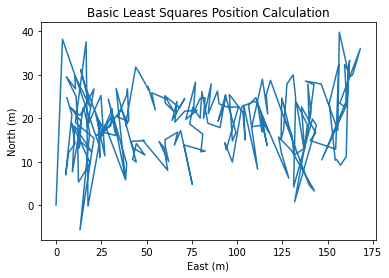

In [14]:
import matplotlib.pyplot as plt
ned_df = pd.DataFrame(ned_list, columns=['N', 'E', 'D'])
plt.plot(ned_df['E'], ned_df['N'])

# Add titles
plt.title('Basic Least Squares Position Calculation')
plt.xlabel("East (m)")
plt.ylabel("North (m)")